# Load Library

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn.functional as F

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Data Preprocessing

In [2]:
#Train data

#The path to save the npy file
dir_save_train_np = 'C:/Users/KDJ/Desktop/KDJ/Code/data/BCCD_Dataset_with_mask/train_np'
os.makedirs(dir_save_train_np, exist_ok=True)

#The path to the data to be preprocessed into the npy file
train_mask_paths = glob.glob('/Users/KDJ/Desktop/KDJ/Code/data/BCCD_Dataset_with_mask/train/mask/*.png')

 #The path to the data to be preprocessed into the npy file
train_original_paths = glob.glob('/Users/KDJ/Desktop/KDJ/Code/data/BCCD_Dataset_with_mask/train/original/*.png')

for i, (train_mask_path, train_original_path) in enumerate(zip(train_mask_paths, train_original_paths)):
    label_ = np.array(Image.open(train_mask_path).resize((256, 256)).convert('RGB')) #Grayscale
    input_ = np.array(Image.open(train_original_path).resize((256, 256)).convert('RGB')) #Grayscale
    np.save(os.path.join(dir_save_train_np, f'label_{i:03d}.npy'), label_)
    np.save(os.path.join(dir_save_train_np, f'input_{i:03d}.npy'), input_)


In [3]:
# Valid data

# The path to save the npy file
dir_save_val_np = 'C:/Users/KDJ/Desktop/KDJ/Code/data/BCCD_Dataset_with_mask/val_np'
os.makedirs(dir_save_val_np, exist_ok=True)

#The path to the data to be preprocessed into the npy file
val_mask_paths = glob.glob('/Users/KDJ/Desktop/KDJ/Code/data/BCCD_Dataset_with_mask/val/mask/*.png')

 #The path to the data to be preprocessed into the npy file
val_original_paths = glob.glob('/Users/KDJ/Desktop/KDJ/Code/data/BCCD_Dataset_with_mask/val/original/*.png')

for i, (val_mask_path, val_original_path) in enumerate(zip(val_mask_paths, val_original_paths)):
    label_ = np.array(Image.open(val_mask_path).resize((256, 256)).convert('RGB')) #Grayscale
    input_ = np.array(Image.open(val_original_path).resize((256, 256)).convert('RGB')) #Grayscale
    np.save(os.path.join(dir_save_val_np, f'label_{i:03d}.npy'), label_)
    np.save(os.path.join(dir_save_val_np, f'input_{i:03d}.npy'), input_)


In [4]:
# Test data

#The path to save the npy file
dir_save_test_np = 'C:/Users/KDJ/Desktop/KDJ/Code/data/BCCD_Dataset_with_mask/test_np'
os.makedirs(dir_save_test_np, exist_ok=True)

#The path to the data to be preprocessed into the npy file
test_mask_paths = glob.glob('/Users/KDJ/Desktop/KDJ/Code/data/BCCD_Dataset_with_mask/test/mask/*.png')

 #The path to the data to be preprocessed into the npy file
test_original_paths = glob.glob('/Users/KDJ/Desktop/KDJ/Code/data/BCCD_Dataset_with_mask/test/original/*.png')

for i, (test_mask_path, test_original_path) in enumerate(zip(test_mask_paths, test_original_paths)):
    label_ = np.array(Image.open(test_mask_path).resize((256, 256)).convert('RGB')) #Grayscale
    input_ = np.array(Image.open(test_original_path).resize((256, 256)).convert('RGB')) #Grayscale
    np.save(os.path.join(dir_save_test_np, f'label_{i:03d}.npy'), label_)
    np.save(os.path.join(dir_save_test_np, f'input_{i:03d}.npy'), input_)


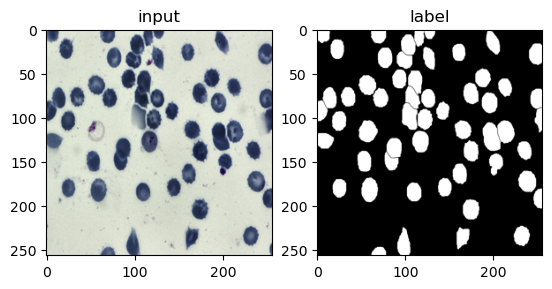

(256, 256, 3)
(256, 256, 3)


In [5]:
## 이미지 시각화
plt.subplot(122)
plt.imshow(label_, cmap='gray')
plt.title('label')

plt.subplot(121)
plt.imshow(input_, cmap='gray')
plt.title('input')

plt.show()

print(np.shape(label_))
print(np.shape(input_))

# Network

In [6]:
class ResUNet(nn.Module):
    def __init__(self):
        super(ResUNet, self).__init__()

        # Convolution + BatchNormalization + Relu
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True): 
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        class ResidualBlock(nn.Module):
            def __init__(self, in_channels, out_channels):
                super(ResidualBlock, self).__init__()
                self.conv_block = nn.Sequential(
                    nn.BatchNorm2d(in_channels),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                )
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                ) 
            
            def forward(self, inputs):
                r = self.conv_block(inputs)
                s = self.shortcut(inputs)
                
                skip = r + s
                return skip

        # Contracting path
        self.enc1_1 = ResidualBlock(in_channels=3, out_channels=64)
        self.enc1_2 = ResidualBlock(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = ResidualBlock(in_channels=64, out_channels=128)
        self.enc2_2 = ResidualBlock(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = ResidualBlock(in_channels=128, out_channels=256)
        self.enc3_2 = ResidualBlock(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = ResidualBlock(in_channels=256, out_channels=512)
        self.enc4_2 = ResidualBlock(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = ResidualBlock(in_channels=512, out_channels=1024)
        
        # Expansive path
        self.dec5_1 = ResidualBlock(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512, 
                                        kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = ResidualBlock(in_channels=2 * 512, out_channels=512)  
        self.dec4_1 = ResidualBlock(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                        kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = ResidualBlock(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = ResidualBlock(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                        kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = ResidualBlock(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = ResidualBlock(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                        kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = ResidualBlock(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = ResidualBlock(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)


    # forward function
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

In [7]:
# state_dict 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = ResUNet().to(device)
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

Model's state_dict:
enc1_1.conv_block.0.weight 	 torch.Size([3])
enc1_1.conv_block.0.bias 	 torch.Size([3])
enc1_1.conv_block.0.running_mean 	 torch.Size([3])
enc1_1.conv_block.0.running_var 	 torch.Size([3])
enc1_1.conv_block.0.num_batches_tracked 	 torch.Size([])
enc1_1.conv_block.2.weight 	 torch.Size([64, 3, 3, 3])
enc1_1.conv_block.2.bias 	 torch.Size([64])
enc1_1.conv_block.3.weight 	 torch.Size([64])
enc1_1.conv_block.3.bias 	 torch.Size([64])
enc1_1.conv_block.3.running_mean 	 torch.Size([64])
enc1_1.conv_block.3.running_var 	 torch.Size([64])
enc1_1.conv_block.3.num_batches_tracked 	 torch.Size([])
enc1_1.conv_block.5.weight 	 torch.Size([64, 64, 3, 3])
enc1_1.conv_block.5.bias 	 torch.Size([64])
enc1_1.shortcut.0.weight 	 torch.Size([64, 3, 3, 3])
enc1_1.shortcut.0.bias 	 torch.Size([64])
enc1_2.conv_block.0.weight 	 torch.Size([64])
enc1_2.conv_block.0.bias 	 torch.Size([64])
enc1_2.conv_block.0.running_mean 	 torch.Size([64])
enc1_2.conv_block.0.running_var 	 torch.Size([64

In [8]:
#check network
net

ResUNet(
  (enc1_1): ResidualBlock(
    (conv_block): Sequential(
      (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
      (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (shortcut): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (enc1_2): ResidualBlock(
    (conv_block): Sequential(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
      (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (shor

# DataLoader 

In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]

        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_label)

    def __getitem__(self, index):
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        # Normalization
        label = label/255.0
        input = input/255.0

        # Create a new channel (axis) if dimension of image and label = 2 (no channel, black and white image)
        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        # # if label is 3 channels, change to 1 channel
        if label.shape[2] == 3:
            label = label[:, :, :1]
        
        data = {'input': input, 'label': label}

        # If transform is defined, fetch data that has been transformed
        if self.transform:
            data = self.transform(data)

        return data

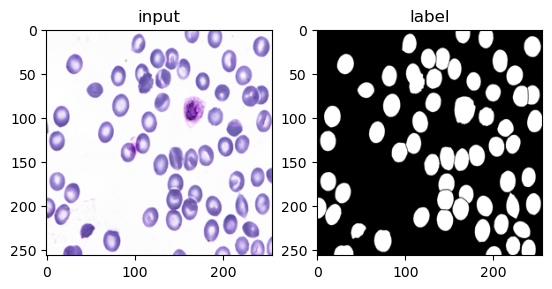

In [10]:
# Check that the dataloader is well implemented

dataset_train = Dataset(data_dir=dir_save_train_np)
data = dataset_train.__getitem__(0) # load a single image
input = data['input']
label = data['label']

plt.subplot(122)
plt.imshow(label.reshape(256,256), cmap='gray')
plt.title('label')

plt.subplot(121)
plt.imshow(input.reshape(256,256,3), cmap='gray')
plt.title('input')

plt.show()

# Transform

In [11]:

class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data

class Normalization(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std

        data = {'label': label, 'input': input}

        return data

class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label': label, 'input': input}

        return data
    
class RandomHorizontalFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        data = {'label': label, 'input': input}

        return data

class RandomVerticalFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label': label, 'input': input}

        return data

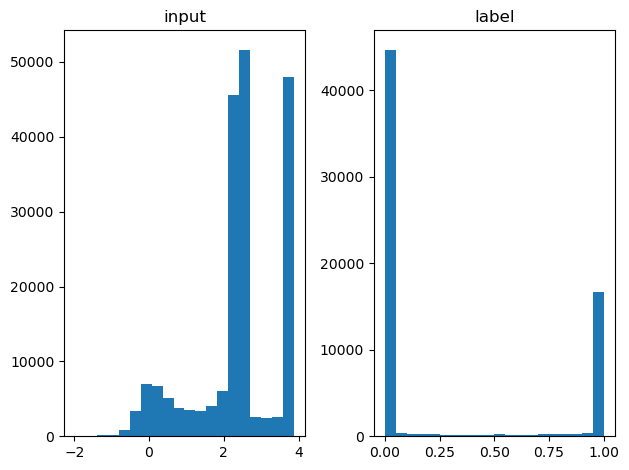

In [12]:
# Check if transform is implemented well
transform = transforms.Compose([Normalization(mean=(0.485, 0.456, 0.406), std=(0.21150185, 0.22043237, 0.15324079)), RandomFlip(), ToTensor()])
dataset_train = Dataset(data_dir=dir_save_train_np, transform=transform)
data = dataset_train.__getitem__(0) # load a single image
input = data['input']
label = data['label']

plt.subplot(122)
plt.hist(label.flatten(), bins=20)
plt.title('label')

plt.subplot(121)
plt.hist(input.flatten(), bins=20)
plt.title('input')

plt.tight_layout()
plt.show()

# Define network Save / Load functions

In [13]:
# Save netw
def save(ckpt_dir, net, optim, epoch, best=False):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    if best:
        torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
                   "%s/model_best_ResUnet_RGB.pth" % ckpt_dir)
    # else:
    #     torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
    #                "%s/model_epoch%d.pth" % (ckpt_dir, epoch))


# Load net
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst = [f for f in ckpt_lst if f.endswith(".pth")]
    ckpt_lst = sorted(ckpt_lst, key=lambda f: int(''.join(filter(str.isdigit, f.split(".")[0]))) if f.split(".")[0].isdigit() else -1)

    if not ckpt_lst:
        epoch = 0
        return net, optim, epoch

    dict_model = torch.load(os.path.join(ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    
    try:
        epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])
    except IndexError:
        epoch = 0

    return net, optim, epoch

# Define IoU metrics

In [14]:
def calculate_iou(prediction, ground_truth):
    prediction = prediction.cpu().numpy()  # Move a CUDA tensor to the CPU and convert it to a NumPy array
    ground_truth = ground_truth.cpu().numpy()  # Move a CUDA tensor to the CPU and convert it to a NumPy array
    
    intersection = np.logical_and(prediction, ground_truth)
    union = np.logical_or(prediction, ground_truth)
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [15]:
# 커스텀 학습률 모니터 함수 정의
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Set training

In [16]:
# Set training parameters
lr = 1e-4
batch_size = 4
num_epoch = 2

base_dir = r'C:\Users\KDJ\Desktop\KDJ\Code'
data_dir = r"C:\Users\KDJ\Desktop\KDJ\Code\data\BCCD_Dataset_with_mask"
ckpt_dir = os.path.join(base_dir, "checkpoint")
log_dir = os.path.join(base_dir, "log")
os.makedirs(ckpt_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

# Transform
transform = transforms.Compose([
    Normalization(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    RandomHorizontalFlip(),  # Randomly flip left and right
    RandomVerticalFlip(),   # Randomly flip up and down
    RandomFlip(),
    ToTensor(), 
])

# DataLoader
dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train_np'), transform=transform)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)

dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val_np'), transform=transform)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=0)

# Create Network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = ResUNet().to(device)

# Define loss function
fn_loss = nn.BCEWithLogitsLoss().to(device)

# Set Optimizer
optim = torch.optim.Adam(net.parameters(), lr=lr)

# # Set other ancillary variables
num_data_train = len(dataset_train)
num_data_val = len(dataset_val)

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)

# # Set other ancillary functions
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)

# Set up a SummaryWriter to use Tensorboard
writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

# Load the trained model, if any
st_epoch = 0
net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim) 

best_loss = float('inf')

# Early stoping
patience_limit = 10
patience_check = 0

# ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=5, min_lr=1e-6)

# Training

In [27]:
for epoch in range(st_epoch + 1, num_epoch + 1):
        net.train()
        loss_arr = []
        iou_arr = []

        for batch, data in enumerate(loader_train, 1):
            # forward pass
            label = data['label'].to(device)
            input = data['input'].to(device)

            output = net(input)

            # backward pass
            optim.zero_grad()

            loss = fn_loss(output, label)
            loss.backward()

            optim.step()

            # Calculate the loss function
            loss_arr += [loss.item()]

            # Calculate the IoU
            prediction = fn_class(output)
            iou = calculate_iou(prediction, label)
            iou_arr += [iou]

            current_lr = get_lr(optim)
            
            print("TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f | IOU %.4f | Patience %d | lr %.7f" %
                    (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr), np.mean(iou_arr), patience_check, current_lr))
            
            # Save Tensorboard
            label = fn_tonumpy(label)
            input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_class(output))

            writer_train.add_image('label', label, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('input', input, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('output', output, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')

        writer_train.add_scalar('loss_ResUnet_RGB', np.mean(loss_arr), epoch)
        writer_train.add_scalar('iou_ResUnet_RGB', np.mean(iou_arr), epoch)

        with torch.no_grad():
            net.eval()
            val_loss_arr = []
            iou_arr = []

            for batch, data in enumerate(loader_val, 1):
                # forward pass
                label = data['label'].to(device)
                input = data['input'].to(device)

                output = net(input)

                # Calculate the loss function
                loss = fn_loss(output, label)

                val_loss_arr += [loss.item()]

                # Calculate the IoU
                prediction = fn_class(output)
                iou = calculate_iou(prediction, label)
                iou_arr += [iou]

                print("VAILD: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f | IOU %.4f | Patience %d | lr %.7f" %
                    (epoch, num_epoch, batch, num_batch_val, np.mean(val_loss_arr), np.mean(iou_arr), patience_check, current_lr))
            
                # Save Tensorboard
                label = fn_tonumpy(label)
                input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
                output = fn_tonumpy(fn_class(output))

                writer_val.add_image('label', label, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                writer_val.add_image('input', input, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                writer_val.add_image('output', output, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')

        writer_val.add_scalar('loss_ResUnet_RGB', np.mean(val_loss_arr), epoch)
        writer_val.add_scalar('iou_ResUnet_RGB', np.mean(iou_arr), epoch)

        mean_loss = np.mean(val_loss_arr)

        # Step the ReduceLROnPlateau scheduler with validation loss
        val_loss = np.mean(val_loss_arr)
        scheduler.step(val_loss)  # 스케줄러에 검증 손실 전달

        # 조기 종료 기능 (Early stopping)
        if mean_loss < best_loss:  # 손실이 개선되면
            best_loss = mean_loss
            patience_check = 0  # 개선이 있을 때마다 참을성 카운터를 리셋
            save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch, best=True)
            
        else:
            patience_check += 1  # 손실이 개선되지 않으면 참을성 카운터 증가

        if patience_check >= patience_limit:  # 조기 종료 조건이 충족되면         
            break
        
        writer_train.close()
        writer_val.close()


TRAIN: EPOCH 0001 / 0002 | BATCH 0001 / 0281 | LOSS 0.0687 | IOU 0.8037 | Patience 1 | lr 0.0001000
TRAIN: EPOCH 0001 / 0002 | BATCH 0002 / 0281 | LOSS 0.0854 | IOU 0.8093 | Patience 1 | lr 0.0001000
TRAIN: EPOCH 0001 / 0002 | BATCH 0003 / 0281 | LOSS 0.0824 | IOU 0.8142 | Patience 1 | lr 0.0001000
TRAIN: EPOCH 0001 / 0002 | BATCH 0004 / 0281 | LOSS 0.0834 | IOU 0.8167 | Patience 1 | lr 0.0001000
TRAIN: EPOCH 0001 / 0002 | BATCH 0005 / 0281 | LOSS 0.0832 | IOU 0.8208 | Patience 1 | lr 0.0001000
TRAIN: EPOCH 0001 / 0002 | BATCH 0006 / 0281 | LOSS 0.0893 | IOU 0.8220 | Patience 1 | lr 0.0001000
TRAIN: EPOCH 0001 / 0002 | BATCH 0007 / 0281 | LOSS 0.0849 | IOU 0.8239 | Patience 1 | lr 0.0001000
TRAIN: EPOCH 0001 / 0002 | BATCH 0008 / 0281 | LOSS 0.0865 | IOU 0.8264 | Patience 1 | lr 0.0001000
TRAIN: EPOCH 0001 / 0002 | BATCH 0009 / 0281 | LOSS 0.0836 | IOU 0.8280 | Patience 1 | lr 0.0001000
TRAIN: EPOCH 0001 / 0002 | BATCH 0010 / 0281 | LOSS 0.0864 | IOU 0.8251 | Patience 1 | lr 0.0001000


# View the graph with Tensorboard


In [40]:
#View the graph with Tensorboard
!tensorboard --logdir ./log 

^C


# Model test

In [23]:
transform = transforms.Compose([Normalization((0.485, 0.456, 0.406), std=(0.5, 0.5, 0.5)), ToTensor()])
dataset_test = Dataset(data_dir=os.path.join(data_dir, 'test_np'), transform=transform)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=0)
print(os.path.join(data_dir, 'test'))
print(len(loader_test))
print(len(dataset_test))
num_data_test = len(dataset_test)
num_batch_test = np.ceil(num_data_test / batch_size)

result_dir = os.path.join(base_dir, 'result')
if not os.path.exists(result_dir):
    os.makedirs(os.path.join(result_dir, 'png'))
    os.makedirs(os.path.join(result_dir, 'numpy'))


net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

with torch.no_grad():
      net.eval()
      loss_arr = []

      for batch, data in enumerate(loader_test, 1):

          label = data['label'].to(device)
          input = data['input'].to(device)

          output = net(input)
          
          loss = fn_loss(output, label)

          loss_arr += [loss.item()]

          print("TEST: BATCH %04d / %04d | LOSS %.4f" %
                (batch, num_batch_test, np.mean(loss_arr)))
          
          label = fn_tonumpy(label)
          input = fn_tonumpy(fn_denorm(input, mean=(0.5), std=(0.5)))
          output = fn_tonumpy(fn_class(output))

          for j in range(label.shape[0]):
              id = num_batch_test * (batch - 1) + j
              # 이미지 값을 0에서 1 사이의 부동 소수점에서 0에서 255 사이의 정수로 변환
              input_image = (input[j].squeeze() * 255).astype(np.uint8)
              plt.imsave(os.path.join(result_dir, 'png', 'input_%04d.png' % id), input_image, cmap='gray')
              plt.imsave(os.path.join(result_dir, 'png', 'label_%04d.png' % id), label[j].squeeze(), cmap='gray')
              plt.imsave(os.path.join(result_dir, 'png', 'output_%04d.png' % id), output[j].squeeze(), cmap='gray')

              np.save(os.path.join(result_dir, 'numpy', 'label_%04d.npy' % id), label[j].squeeze())
              np.save(os.path.join(result_dir, 'numpy', 'input_%04d.npy' % id), input[j].squeeze())
              np.save(os.path.join(result_dir, 'numpy', 'output_%04d.npy' % id), output[j].squeeze())

print("AVERAGE TEST: BATCH %04d / %04d | LOSS %.4f" %
        (batch, num_batch_test, np.mean(loss_arr)))

C:\Users\KDJ\Desktop\KDJ\Code\data\BCCD_Dataset_with_mask\test
33
132
TEST: BATCH 0001 / 0033 | LOSS 0.6085
TEST: BATCH 0002 / 0033 | LOSS 0.4957
TEST: BATCH 0003 / 0033 | LOSS 0.3800
TEST: BATCH 0004 / 0033 | LOSS 0.3152
TEST: BATCH 0005 / 0033 | LOSS 0.2971
TEST: BATCH 0006 / 0033 | LOSS 0.3271
TEST: BATCH 0007 / 0033 | LOSS 0.3058
TEST: BATCH 0008 / 0033 | LOSS 0.3229
TEST: BATCH 0009 / 0033 | LOSS 0.2971
TEST: BATCH 0010 / 0033 | LOSS 0.2783
TEST: BATCH 0011 / 0033 | LOSS 0.2678
TEST: BATCH 0012 / 0033 | LOSS 0.2964
TEST: BATCH 0013 / 0033 | LOSS 0.2815
TEST: BATCH 0014 / 0033 | LOSS 0.2798
TEST: BATCH 0015 / 0033 | LOSS 0.2826
TEST: BATCH 0016 / 0033 | LOSS 0.2710
TEST: BATCH 0017 / 0033 | LOSS 0.2863
TEST: BATCH 0018 / 0033 | LOSS 0.3033
TEST: BATCH 0019 / 0033 | LOSS 0.3066
TEST: BATCH 0020 / 0033 | LOSS 0.3480
TEST: BATCH 0021 / 0033 | LOSS 0.3438
TEST: BATCH 0022 / 0033 | LOSS 0.3311
TEST: BATCH 0023 / 0033 | LOSS 0.3206
TEST: BATCH 0024 / 0033 | LOSS 0.3161
TEST: BATCH 0025 /

# Visualizing the results

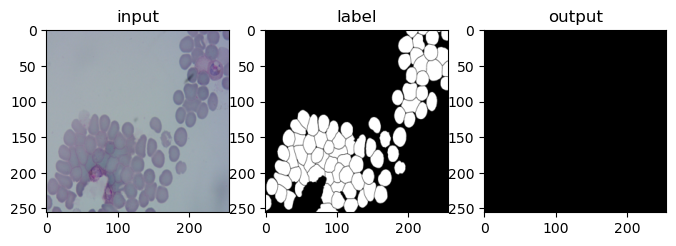

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


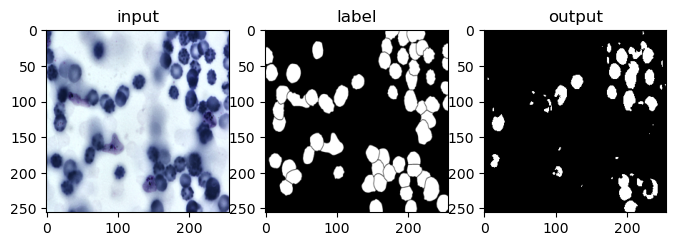

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


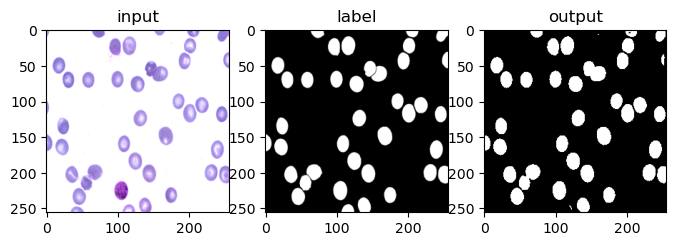

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


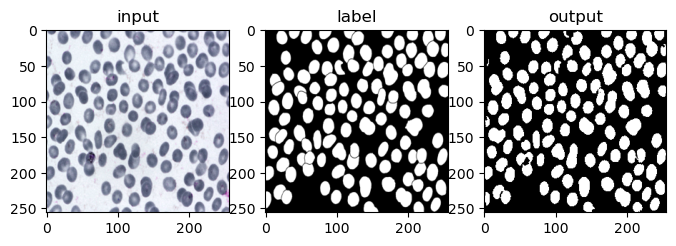

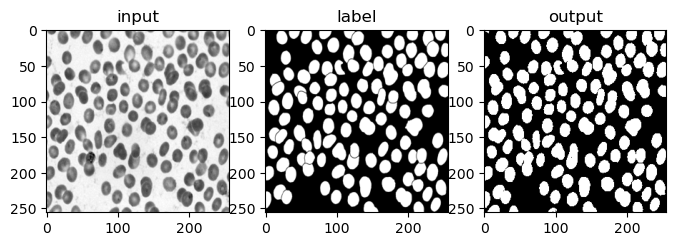

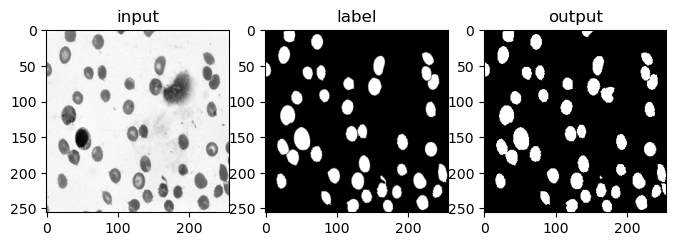

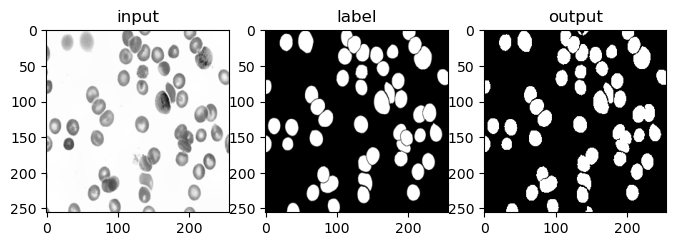

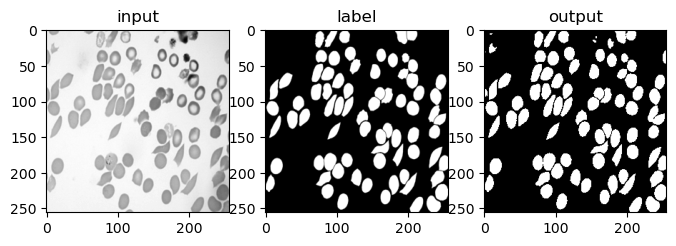

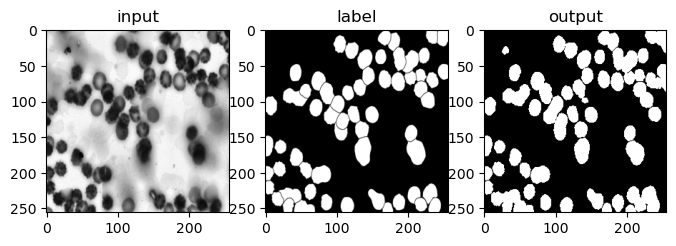

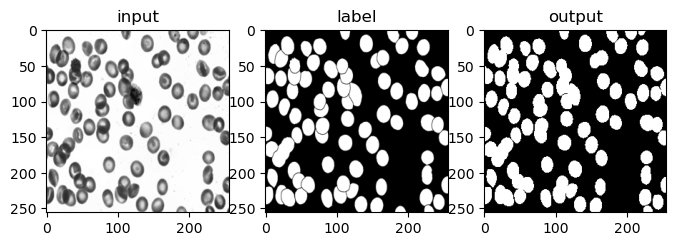

In [24]:
for i in range(10):
    ##
    lst_data = os.listdir(os.path.join(result_dir, 'numpy'))

    lst_label = [f for f in lst_data if f.startswith('label')]
    lst_input = [f for f in lst_data if f.startswith('input')]
    lst_output = [f for f in lst_data if f.startswith('output')]

    lst_label.sort()
    lst_input.sort()
    lst_output.sort()

    ##
    id = i

    label = np.load(os.path.join(result_dir,"numpy", lst_label[id]))
    input = np.load(os.path.join(result_dir,"numpy", lst_input[id]))
    output = np.load(os.path.join(result_dir,"numpy", lst_output[id]))

    ##
    plt.figure(figsize=(8,6))
    plt.subplot(131)
    plt.imshow(input, cmap='gray')
    plt.title('input')

    plt.subplot(132)
    plt.imshow(label, cmap='gray')
    plt.title('label')

    plt.subplot(133)
    plt.imshow(output, cmap='gray')
    plt.title('output')

    plt.show()


# Inference

In [ ]:

infer_data_paths = glob.glob('path/*png')

dir_save_infer_np = 'path/infer_np'

if not os.path.exists(dir_save_infer_np):
    os.makedirs(dir_save_infer_np)

for i, infer_data_path in enumerate(infer_data_paths):
    infer_data = np.array(Image.open(infer_data_path).resize((256, 256)).convert('L'))
    input_ = np.asarray(infer_data)
    np.save(os.path.join(dir_save_infer_np, 'input_%03d.npy' % i), input_)


In [ ]:
class Dataset_infer(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        lst_input = [f for f in lst_data if f.startswith('input')]

        lst_input.sort()

        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_input)

    def __getitem__(self, index):
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        input = input/255.0

        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input': input}

        if self.transform:
            data = self.transform(data)

        return data
    
class ToTensor_infer(object):
    def __call__(self, data):
        input = data['input']

        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'input': torch.from_numpy(input)}

        return data

class Normalization_infer:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        input = data['input']
        input = (input - self.mean) / self.std
        data = {'input': input}
        return data

In [ ]:
base_dir = r'path'
infer_base_dir = r'path'
infer_data_dir = r"path"
ckpt_dir = os.path.join(base_dir, "checkpoint")

transform = transforms.Compose([Normalization_infer(mean=0.5, std=0.5), ToTensor_infer()])

dataset_test = Dataset_infer(data_dir=os.path.join(infer_data_dir, 'infer_np'), transform=transform)
loader_test = DataLoader(dataset_test, batch_size=8, shuffle=False, num_workers=0)

num_data_test = len(dataset_test)
num_batch_test = np.ceil(num_data_test / batch_size)

result_dir = os.path.join(infer_base_dir, 'result')
if not os.path.exists(result_dir):
    os.makedirs(os.path.join(result_dir, 'png'))
    os.makedirs(os.path.join(result_dir, 'numpy'))

net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

with torch.no_grad():
    net.eval()

    num = 1
    
    for batch, data in enumerate(loader_test, 1):

        input = data['input'].to(device)

        output = net(input)

        input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
        output = fn_tonumpy(fn_class(output))

        for j in range(input.shape[0]):
            id = num
            num += 1
            plt.imsave(os.path.join(result_dir, 'png', 'input_%04d.png' % id), input[j].squeeze(), cmap='gray')
            plt.imsave(os.path.join(result_dir, 'png', 'output_%04d.png' % id), output[j].squeeze(), cmap='gray')

            np.save(os.path.join(result_dir, 'numpy', 'input_%04d.npy' % id), input[j].squeeze())
            np.save(os.path.join(result_dir, 'numpy', 'output_%04d.npy' % id), output[j].squeeze())


In [ ]:
for i in range(10):
    ##
    lst_data = os.listdir(os.path.join(result_dir, 'numpy'))

    lst_input = [f for f in lst_data if f.startswith('input')]
    lst_output = [f for f in lst_data if f.startswith('output')]

    lst_input.sort()
    lst_output.sort()

    ##
    id = i

    input = np.load(os.path.join(result_dir,"numpy", lst_input[id]))
    output = np.load(os.path.join(result_dir,"numpy", lst_output[id]))

    ##
    plt.figure(figsize=(8,6))
    plt.subplot(131)
    plt.imshow(input, cmap='gray')
    plt.title('input')

    plt.subplot(132)
    plt.imshow(output, cmap='gray')
    plt.title('output')

    plt.show()
